# Project NLP & Deep Learning : Tobacco

Rassim ABDOU

In [2]:
# Importing tools
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

import ast
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from keras.preprocessing import text, sequence
from nn_utils import TrainingHistory



# Ignore warning 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
%matplotlib inline

In [3]:
# Reading the documents texts in a list 'text_data'
text_data = []
path='Tobacco3482-OCR'
for file in glob.glob(os.path.join(path,'*')):
    for text_file in glob.glob(os.path.join(file,'*.txt')):
        with open(text_file, 'r') as myfile:
            text_data.append(myfile.read().replace('\n', '')) 
            
# Print the length of the text documents
len(text_data)

3482

In [4]:
df = pd.read_csv('tobacco-lab_data_Tobacco3482.csv')
print("Shape :", df.shape)
df.head()

Shape : (3482, 2)


,img_path,label
0,Advertisement/0000136188.jpg,Advertisement
1,Advertisement/0000435350.jpg,Advertisement
2,Advertisement/0000556056.jpg,Advertisement
3,Advertisement/0030048095.jpg,Advertisement
4,Advertisement/0030048989.jpg,Advertisement


#### Replacing the image_names by its own content

In [5]:
for i, content in enumerate(text_data):  
    df.loc[i, 'img_path'] = content 
    
df.head()

,img_path,label
0,A Mpertant as yarsesiye teaetered cabiieess. B...,Advertisement
1,TE che fitmm66400 7127KOOLS are the only cigar...,Advertisement
2,so ARN Rr nrBWR Ga ||Vending Operators Now the...,Advertisement
3,"MARCH 24,19 VO — 3. Tersrearep ‘ yi ills :i We...",Advertisement
4,~Spend a milder moment qswith Raleigh.=A speci...,Advertisement


In [6]:
nans = df.isnull().sum() / len(df.index) # proportion de NaN dans chaque colonne
nans = nans.sort_values(ascending = False)
print("Attribut    Taux de NaN")
print(nans.to_string())

Attribut    Taux de NaN
label       0.0
img_path    0.0


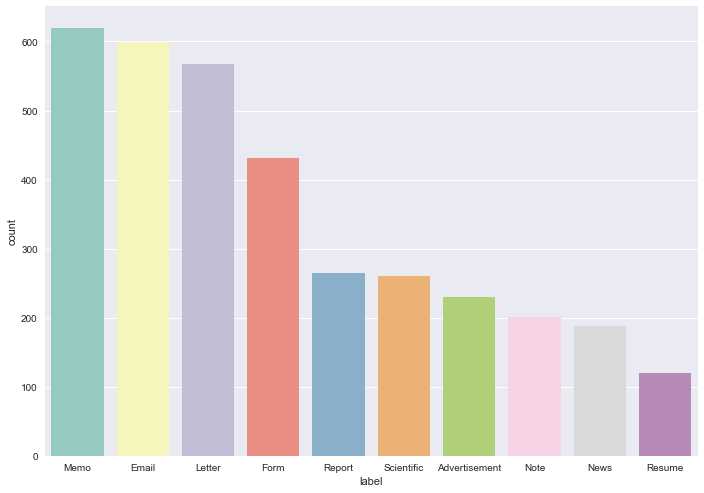

In [7]:
# Plot the statistics of labels
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.countplot(x='label', data=df, order = df['label'].value_counts().index, palette="Set3")

### Train, Validation & Test data

In [58]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[0]], df[df.columns[1]], test_size=0.30)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.50)

In [59]:
print("Number of train data :", len(X_train))
print("Number of dev data :", len(X_dev))
print("Number of test data :", len(X_test))

Number of train data : 2437
Number of dev data : 523
Number of test data : 522


- We'll use two different text structures which are Bag of words and TF-IDF. Then compare how the models that we'll define deal with those sturctures and which one gives the best performances with the best hyperparameters. 

### Data representations : (BoW & TF-IDF)

In [60]:
def bow_rep(X_train, X_dev, X_test):
    # Create document vectors
    count_vectorizer = CountVectorizer()
    vectorizer = CountVectorizer(max_features=2000)
    vectorizer.fit(X_train)
    X_train_counts = vectorizer.transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
    X_dev_counts = vectorizer.transform(X_dev)
    
    return X_train_counts, X_dev_counts, X_test_counts
    
def tf_idf_rep(X_train_counts, X_dev_counts, X_test_counts):

    tf_transformer = TfidfTransformer().fit(X_train_counts)
    X_train_tf = tf_transformer.transform(X_train_counts)
    X_dev_tf = tf_transformer.transform(X_dev_counts)
    X_test_tf = tf_transformer.transform(X_test_counts)
    
    return X_train_tf, X_dev_tf, X_test_tf

#### Trainning a Naive Bayes classifier

- The idea is based on running multiple Naïve bayes classifiers with several values of the hyperparameter 'alpha', starting from without smoothing (alpha = 0) to 5.0 with a step or 1. And apply a 5-fold cross validation to test the model accuracy by computer the mean of the 5 experiments
- We'll start with the BoW representation and then TF-IDF.

##### Naïve Bayes with Countvectorizer :

In [61]:
X_train_counts, X_dev_counts, X_test_counts = bow_rep(X_train, X_dev, X_test)

In [62]:
X_train_counts.A.shape

(2437, 2000)

In [63]:
parameters = {'alpha' : [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]}

nb_classifier = MultinomialNB()
grid_search_clf = GridSearchCV(nb_classifier, parameters, cv=5, return_train_score=True)
grid_search_clf.fit(X_train_counts, y_train)
res = grid_search_clf.cv_results_

for i in range(1, 7):
    print('Rank', i)
    ind = np.where(res['rank_test_score'] == i)
    print('Alpha : {}'.format(res['params'][ind[0][0]]['alpha']))
    print('The mean accuracy : {}\n'.format(round(res['mean_test_score'][ind][0], 3)))

Rank 1
Alpha : 1.0
The mean accuracy : 0.688

Rank 2
Alpha : 2.0
The mean accuracy : 0.685

Rank 3
Alpha : 3.0
The mean accuracy : 0.679

Rank 4
Alpha : 4.0
The mean accuracy : 0.676

Rank 5
Alpha : 5.0
The mean accuracy : 0.669

Rank 6
Alpha : 0.0
The mean accuracy : 0.632



-  According to the grid search approach, the default value of alpha (1.0) gives the best performances and so we'll build a real Naïve bayes model and compute its accuracy on the test data then discuss the precisions and recalls along with the confusion matrix.

In [64]:
# Define the model
nb_classifier = MultinomialNB(alpha=1.)

# Fit the model
nb_classifier.fit(X_train_counts, y_train)


pred_train = nb_classifier.predict(X_train_counts)
pred_dev = nb_classifier.predict(X_dev_counts)
pred_test = nb_classifier.predict(X_test_counts)



print("The accuracy on train set : ", metrics.accuracy_score(y_train, pred_train))

print("The accuracy on dev set : ", metrics.accuracy_score(y_dev, pred_dev))

print("The accuracy on test set : ", metrics.accuracy_score(y_test, pred_test))

The accuracy on train set :  0.805088223225277
The accuracy on dev set :  0.7131931166347992
The accuracy on test set :  0.7183908045977011


Classification matrix
------------------ CountVectorizer ------------------

               precision    recall  f1-score   support

Advertisement       0.68      0.66      0.67        35
        Email       0.94      0.93      0.93        96
         Form       0.76      0.79      0.77        61
       Letter       0.67      0.64      0.65        80
         Memo       0.66      0.74      0.70        95
         News       0.62      0.72      0.67        29
         Note       0.64      0.36      0.46        25
       Report       0.49      0.53      0.51        47
       Resume       0.95      1.00      0.97        19
   Scientific       0.69      0.57      0.62        35

  avg / total       0.72      0.72      0.72       522


Confusion matrix 

CountVectorizer confusion matrix


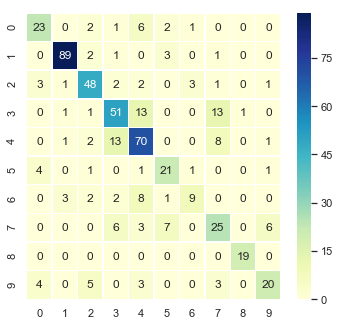

In [76]:
print('Classification matrix')
print('------------------ CountVectorizer ------------------\n')
print(classification_report(y_test, pred_test))
print()

# confusion matrix
print('Confusion matrix \n')
print('CountVectorizer confusion matrix')
sns.set(rc={'figure.figsize':(5.7,5.27)})
cm_data = confusion_matrix(y_test, pred_test)
cm = sns.heatmap(cm_data, annot=True, cmap="YlGnBu", linewidths=.5)

##### Naïve Bayes with  TF-IDF :

In [80]:
X_train_tf, X_dev_tf, X_test_tf = tf_idf_rep(X_train_counts, X_dev_counts, X_test_counts)

In [81]:
parameters = {'alpha' : [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]}

nb_classifier = MultinomialNB()
grid_search_clf = GridSearchCV(nb_classifier, parameters, cv=5, return_train_score=True)
grid_search_clf.fit(X_train_tf, y_train)
res = grid_search_clf.cv_results_

for i in range(1, 7):
    print('Rank', i)
    ind = np.where(res['rank_test_score'] == i)
    print('Alpha : {}'.format(res['params'][ind[0][0]]['alpha']))
    print('The mean accuracy : {}\n'.format(round(res['mean_test_score'][ind][0], 3)))

Rank 1
Alpha : 1.0
The mean accuracy : 0.625

Rank 2
Alpha : 0.0
The mean accuracy : 0.622

Rank 3
Alpha : 2.0
The mean accuracy : 0.572

Rank 4
Alpha : 3.0
The mean accuracy : 0.533

Rank 5
Alpha : 4.0
The mean accuracy : 0.503

Rank 6
Alpha : 5.0
The mean accuracy : 0.483



In [82]:
# train the classifier
nb_classifier.fit(X_train_tf, y_train)

pred_train_tf = nb_classifier.predict(X_train_tf)
pred_dev_tf = nb_classifier.predict(X_dev_tf)
pred_test_tf = nb_classifier.predict(X_test_tf)



print("The accuracy on train set : ", metrics.accuracy_score(y_train, pred_train_tf))

print("The accuracy on dev set : ", metrics.accuracy_score(y_dev, pred_dev_tf))

print("The accuracy on test set : ", metrics.accuracy_score(y_test, pred_test_tf))

The accuracy on train set :  0.7287648748461223
The accuracy on dev set :  0.6787762906309751
The accuracy on test set :  0.6283524904214559


---------------------- TF-IDF -----------------------

               precision    recall  f1-score   support

Advertisement       0.91      0.29      0.43        35
        Email       0.91      0.94      0.92        96
         Form       0.63      0.75      0.69        61
       Letter       0.43      0.74      0.54        80
         Memo       0.52      0.81      0.63        95
         News       0.82      0.31      0.45        29
         Note       1.00      0.04      0.08        25
       Report       1.00      0.06      0.12        47
       Resume       1.00      0.95      0.97        19
   Scientific       0.75      0.43      0.55        35

  avg / total       0.73      0.63      0.59       522


TF-TDF


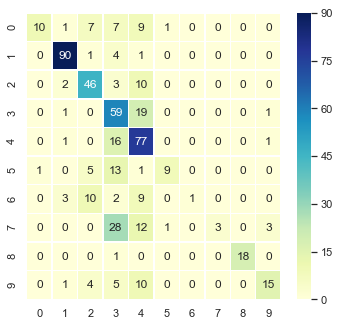

In [83]:

print('---------------------- TF-IDF -----------------------\n')
print(classification_report(y_test, pred_test_tf))
print()
print('TF-TDF')
sns.set(rc={'figure.figsize':(5.7,5.27)})
cm_data = confusion_matrix(y_test, pred_test_tf)
cm = sns.heatmap(cm_data, annot=True, cmap="YlGnBu", linewidths=.5)

### Neural Network Classifier

##### MLP Classifier with BoW :

In [88]:
mlp_clf = MLPClassifier(activation='relu', alpha=1.0, verbose=2, batch_size=50)

# train the classifier
mlp_clf.fit(X_train_counts, y_train)

pred_train_mlp = mlp_clf.predict(X_train_counts)
pred_dev_mlp = mlp_clf.predict(X_dev_counts)
pred_test_mlp = mlp_clf.predict(X_test_counts)



print("The accuracy on train set : ", metrics.accuracy_score(y_train, pred_train_mlp))

print("The accuracy on dev set : ", metrics.accuracy_score(y_dev, pred_dev_mlp))

print("The accuracy on test set : ", metrics.accuracy_score(y_test, pred_test_mlp))

Iteration 1, loss = 3.01635157
Iteration 2, loss = 1.67422493
Iteration 3, loss = 1.27392179
Iteration 4, loss = 1.10017658
Iteration 5, loss = 1.01437123
Iteration 6, loss = 0.96831290
Iteration 7, loss = 0.94002807
Iteration 8, loss = 0.92530639
Iteration 9, loss = 0.89741989
Iteration 10, loss = 0.89642487
Iteration 11, loss = 0.89536839
Iteration 12, loss = 0.87996434
Iteration 13, loss = 0.87143392
Iteration 14, loss = 0.87523253
Iteration 15, loss = 0.87851260
Iteration 16, loss = 0.87611015
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
The accuracy on train set :  0.9421419778416086
The accuracy on dev set :  0.751434034416826
The accuracy on test set :  0.7547892720306514


---------------------- MLP Classifier with TF-IDF representation -----------------------

               precision    recall  f1-score   support

Advertisement       0.62      0.51      0.56        35
        Email       0.96      0.94      0.95        96
         Form       0.81      0.82      0.81        61
       Letter       0.69      0.71      0.70        80
         Memo       0.66      0.81      0.73        95
         News       0.89      0.55      0.68        29
         Note       0.53      0.84      0.65        25
       Report       0.65      0.51      0.57        47
       Resume       1.00      1.00      1.00        19
   Scientific       0.65      0.43      0.52        35

  avg / total       0.75      0.74      0.74       522


MLP-TF-TDF


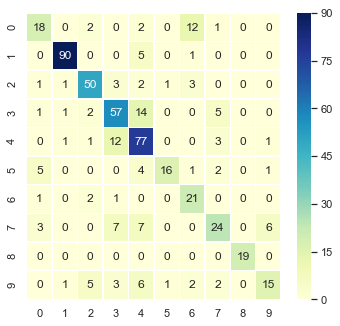

In [86]:
print('---------------------- MLP Classifier with TF-IDF representation -----------------------\n')
print(classification_report(y_test, pred_test_mlp))
print()
print('MLP-TF-TDF')
sns.set(rc={'figure.figsize':(5.7,5.27)})
cm_data = confusion_matrix(y_test, pred_test_mlp)
cm = sns.heatmap(cm_data, annot=True, cmap="YlGnBu", linewidths=.5)